In [29]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from scipy.spatial.distance import pdist, squareform

color_mapping12 = {
    "C>A": "deepskyblue",
    "G>T": "deepskyblue",
    "C>G": "black",
    "G>C": "black",
    "C>T": "red",
    "G>A": "red",
    "T>A": "silver",
    "A>T": "silver",
    "T>C": "yellowgreen",
    "A>G": "yellowgreen",
    "T>G": "pink",
    "A>C": "pink",
}

In [21]:
spectra = pd.read_csv('./data/viral_spectra_dataset.csv').sort_values(['Type', 'G>T'])
linages = pd.read_csv('./data/vir_linages.csv')
linages['taxid'] = linages['taxid'].astype(str)

spectra = spectra.merge(linages[['taxid', 'family', 'order']], 'left')

spectra.loc[spectra.taxname.str.len() > 25, 'taxname'] = \
    spectra.loc[spectra.taxname.str.len() > 25, 'virusname']

spectra_long = spectra.melt(
    ['taxname', 'Type', 'virusname', 'df', 'taxid'],
    list(color_mapping12.keys()),
    var_name='Mut', value_name='MutSpec')
print(len(spectra_long))
spectra_long['label'] = spectra_long.taxname.str[:25] + ' (' + spectra_long.Type + ')'
spectra_long

444


,taxname,Type,virusname,df,taxid,Mut,MutSpec,label
0,Hepacivirus hominis,+,HCV,nemu,3052230,C>A,0.012574,Hepacivirus hominis (+)
1,Enterovirus D,+,evD,nemu,138951,C>A,0.010681,Enterovirus D (+)
2,Dengue virus,+,denv,nemu,12637,C>A,0.025002,Dengue virus (+)
3,Enterovirus A,+,evA,nemu,138948,C>A,0.011674,Enterovirus A (+)
4,FMDV,+,FMDV,nemu,12110,C>A,0.014670,FMDV (+)
...,...,...,...,...,...,...,...,...
439,Piscine orthoreovirus,ds,PRV,nemu,1157337,A>C,0.027282,Piscine orthoreovirus (ds)
440,Mammalian orthoreovirus,ds,MRV,nemu,351073,A>C,0.025958,Mammalian orthoreovirus (ds)
441,Avian orthoreovirus,ds,aorv,nemu,38170,A>C,0.044178,Avian orthoreovirus (ds)
442,Banna virus,ds,BAV,nemu,77763,A>C,0.018818,Banna virus (ds)


In [3]:
import warnings
warnings.filterwarnings("ignore")

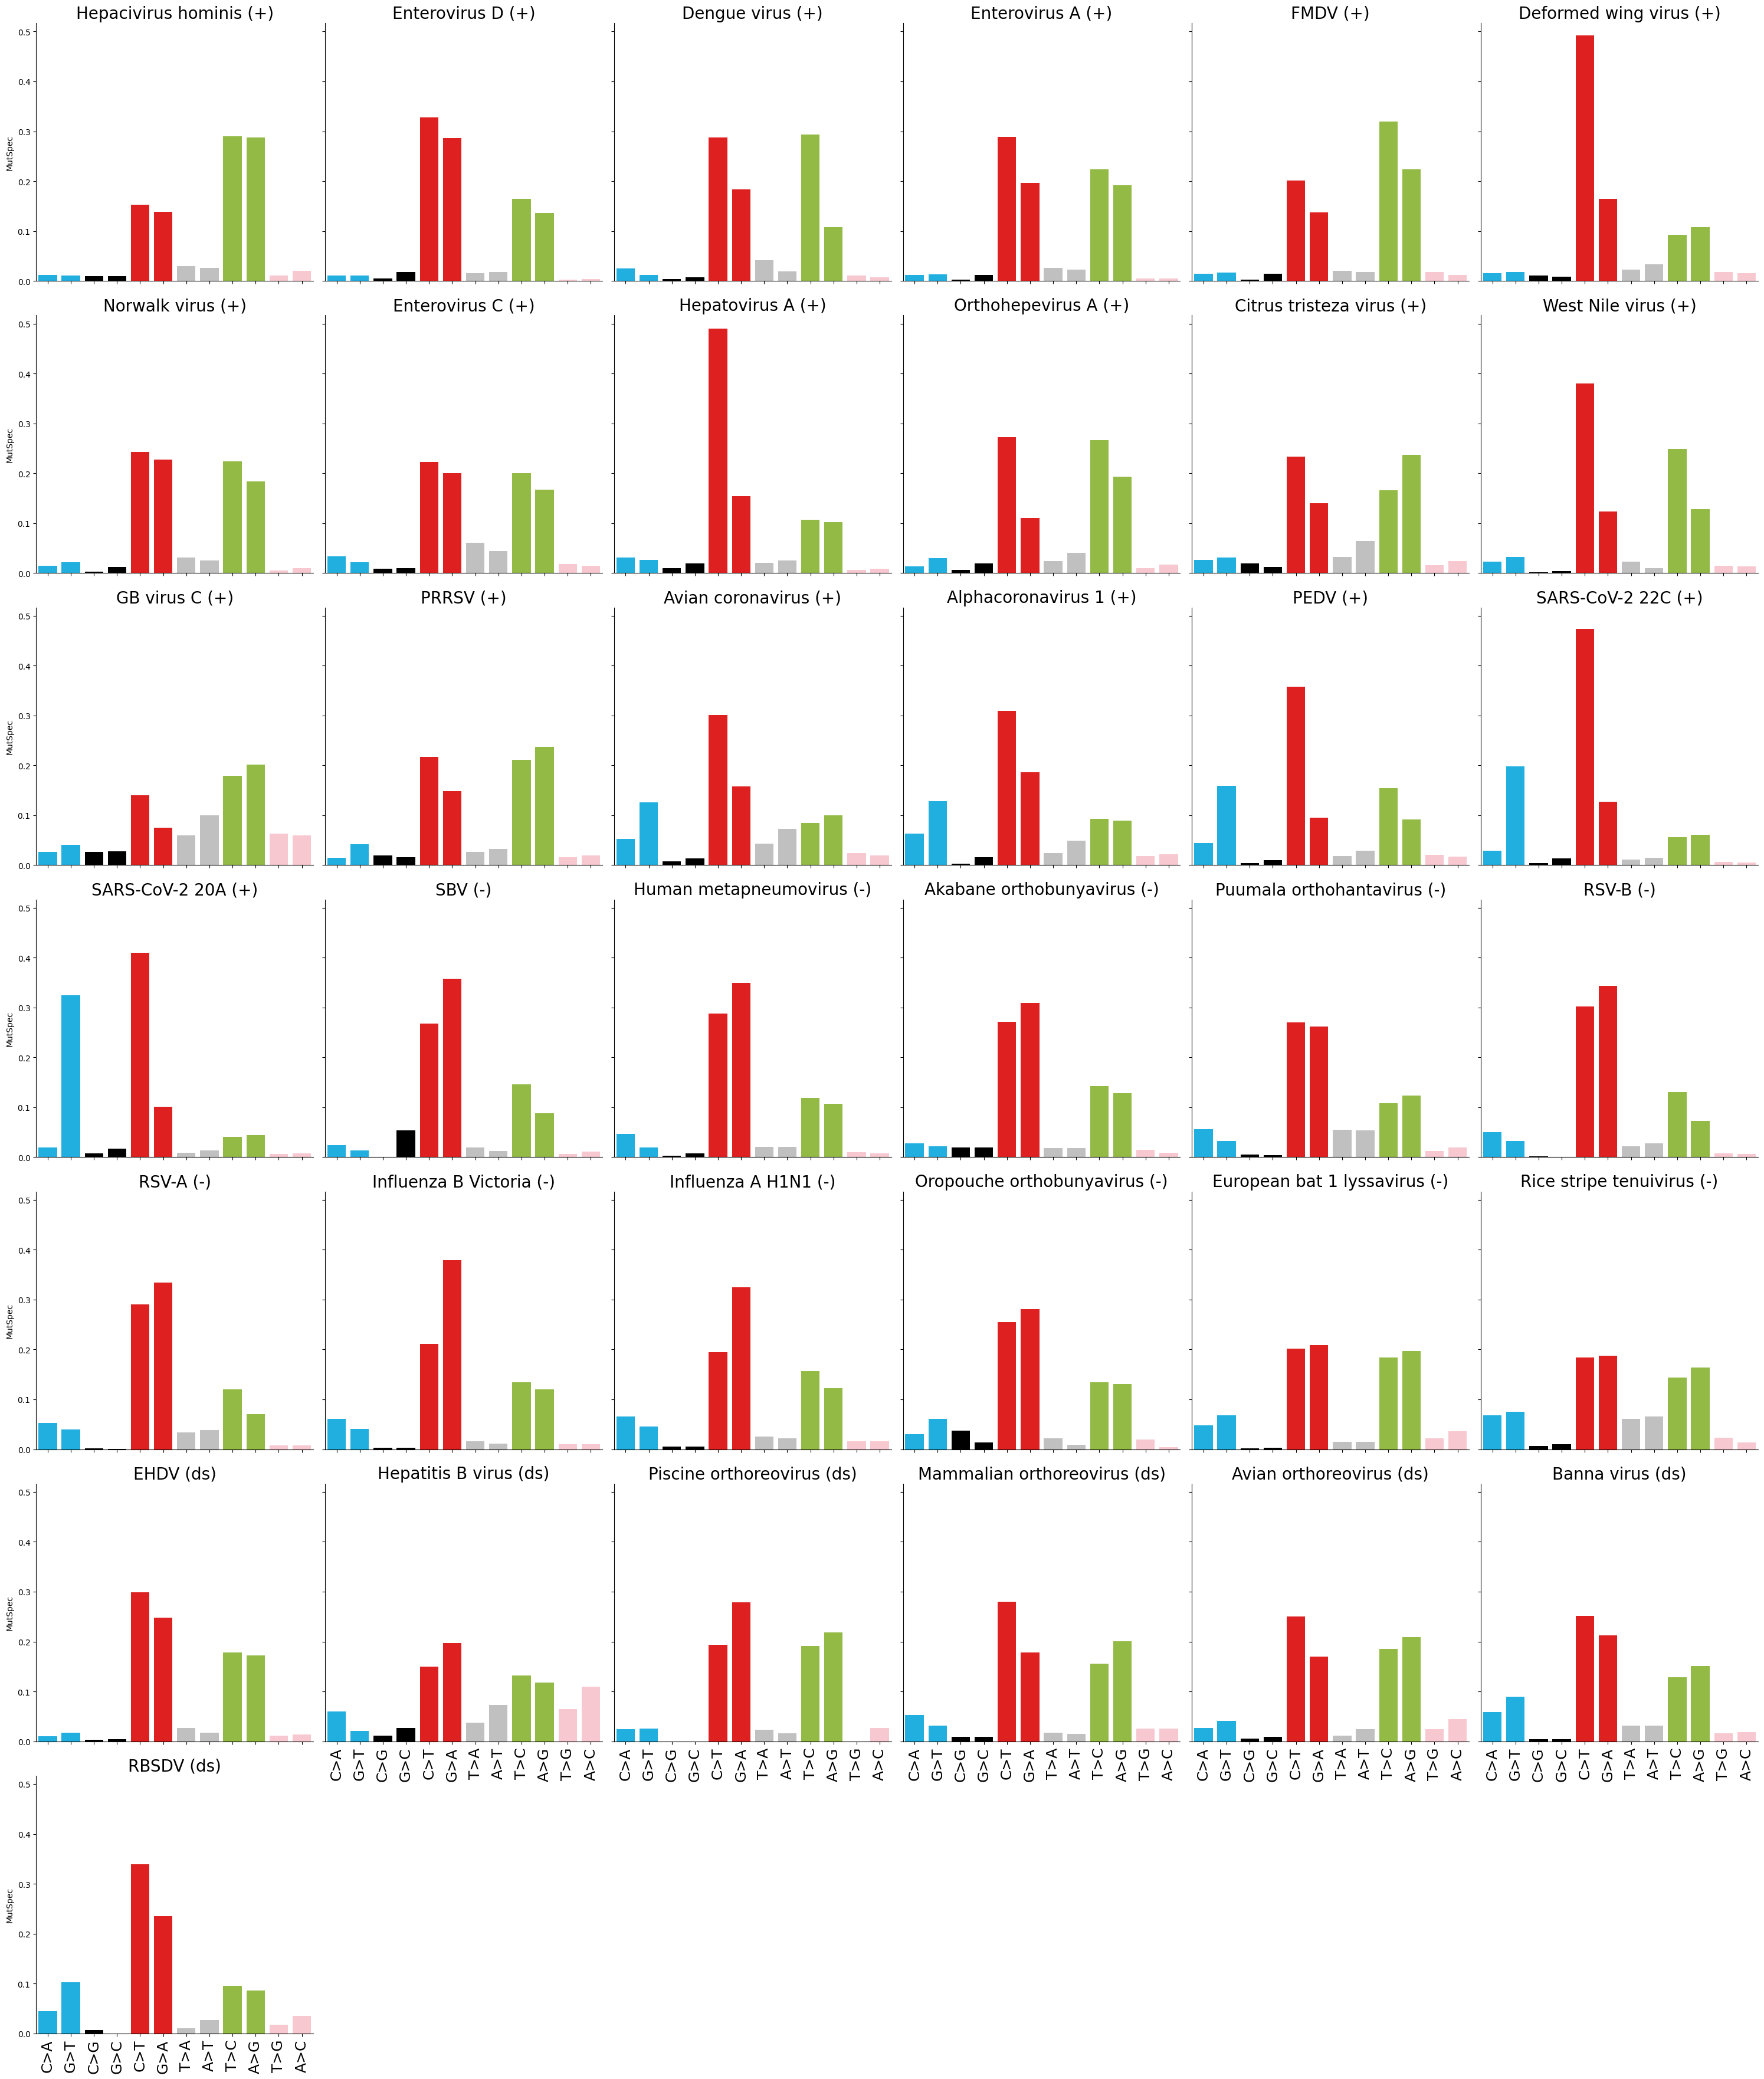

In [4]:
g = sns.catplot(spectra_long, x='Mut', y='MutSpec', col='label', 
            col_wrap=6, palette=color_mapping12, kind='bar', 
            order=color_mapping12.keys(), sharey=True)
g.set_titles('{col_name}')
g.set_xlabels('')
for ax in g.axes:
    ax.set_title(ax.get_title(), fontsize=20)
    ax.set_xticklabels(color_mapping12.keys(), fontsize=18, rotation=90)
g.savefig('./figures/spectra_dataset_barplots.pdf')

In [42]:
for tax in spectra.dropna(subset='family').family.unique():
    ms = spectra[spectra.family == tax].iloc[:, :12]
    if len(ms) > 1:
        cossim = pdist(ms, 'cosine')
        cossim_mean = cossim.mean()
        print(f"{tax}:\t{cossim_mean:.3f}\t{(1-cossim).round(2)}")
    else:
        print(tax)


Picornaviridae__12058:	0.060	[0.97 0.84 0.95 0.95 0.99 0.94]
Flaviviridae__11050:	0.033	[0.97]
Iflaviridae__699189
Caliciviridae__11974
Hepeviridae__291484
Closteroviridae__69973
Arteriviridae__76803
Coronaviridae__11118:	0.028	[0.99 0.96 0.96]
Pneumoviridae__11244
Peribunyaviridae__1980416
Rhabdoviridae__11270
Reoviridae__10880:	0.050	[0.96 0.98 0.97 0.97 0.94 0.95 0.96 0.94 0.86 0.99 0.97 0.93 0.96 0.9
 0.97]


Picornaviridae__12058:	0.060	[0.97 0.84 0.95 0.95 0.99 0.94]
Flaviviridae__11050:	0.033	[0.97]
Coronaviridae__11118:	0.028	[0.99 0.96 0.96]
Reoviridae__10880:	0.050	[0.96 0.98 0.97 0.97 0.94 0.95 0.96 0.94 0.86 0.99 0.97 0.93 0.96 0.9
 0.97]


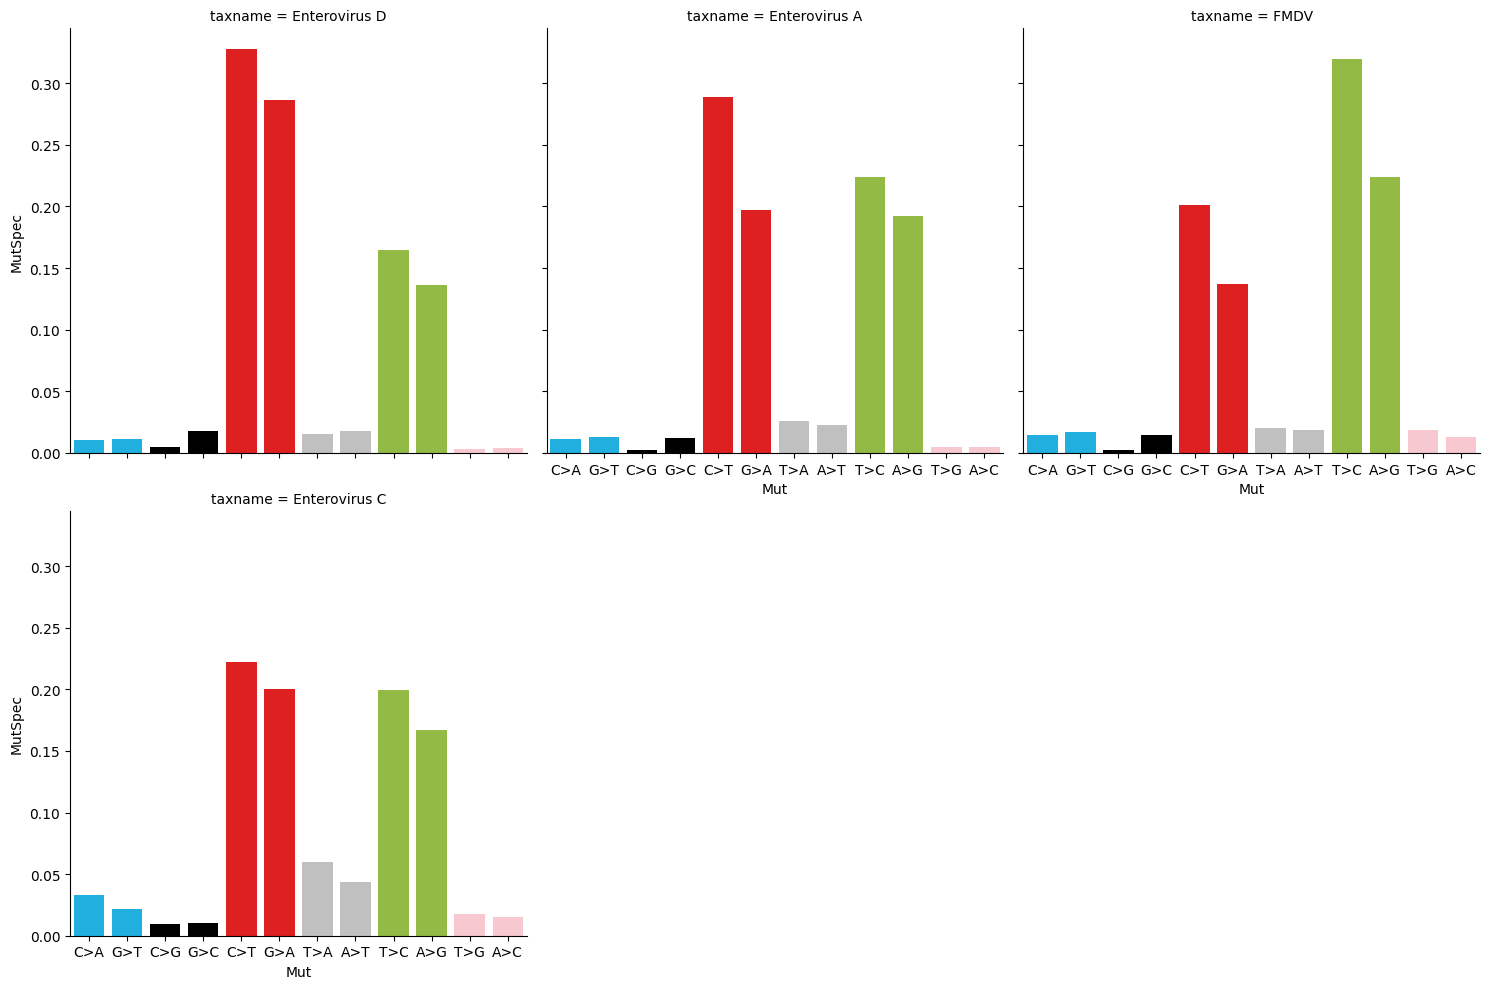

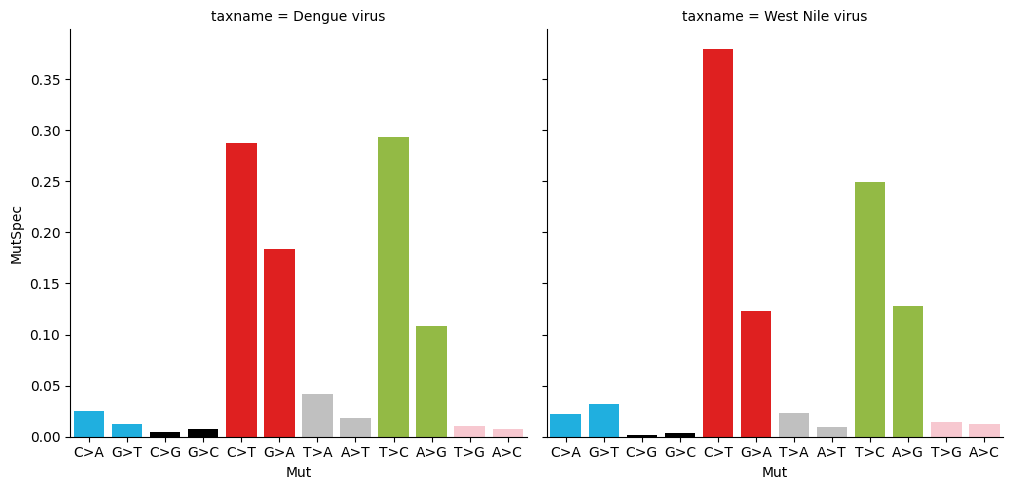

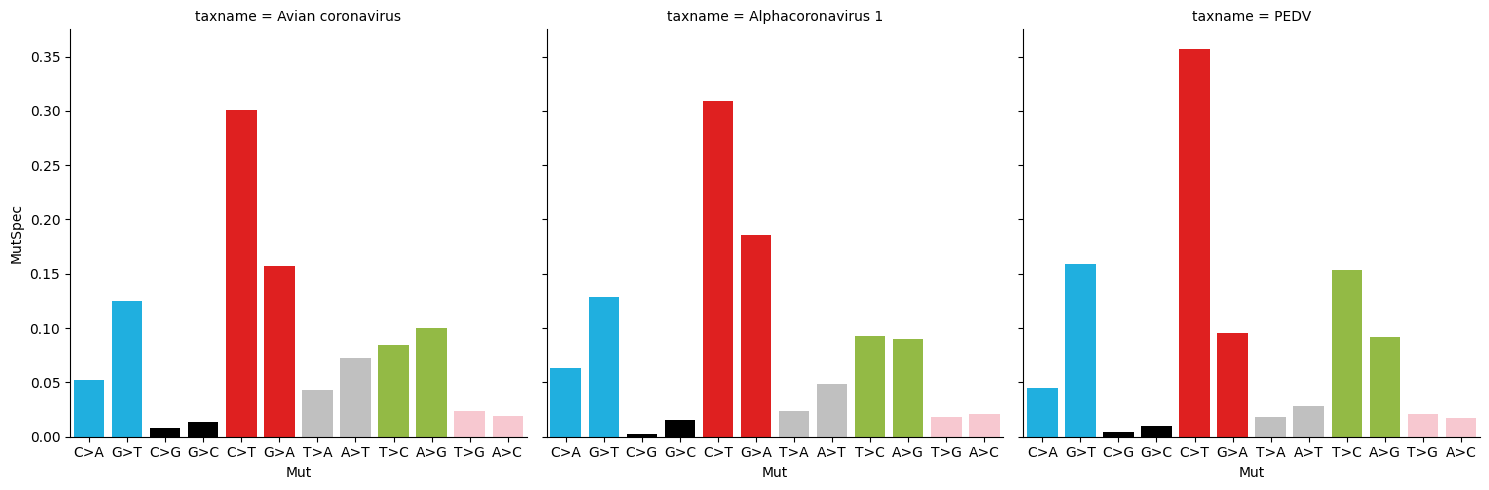

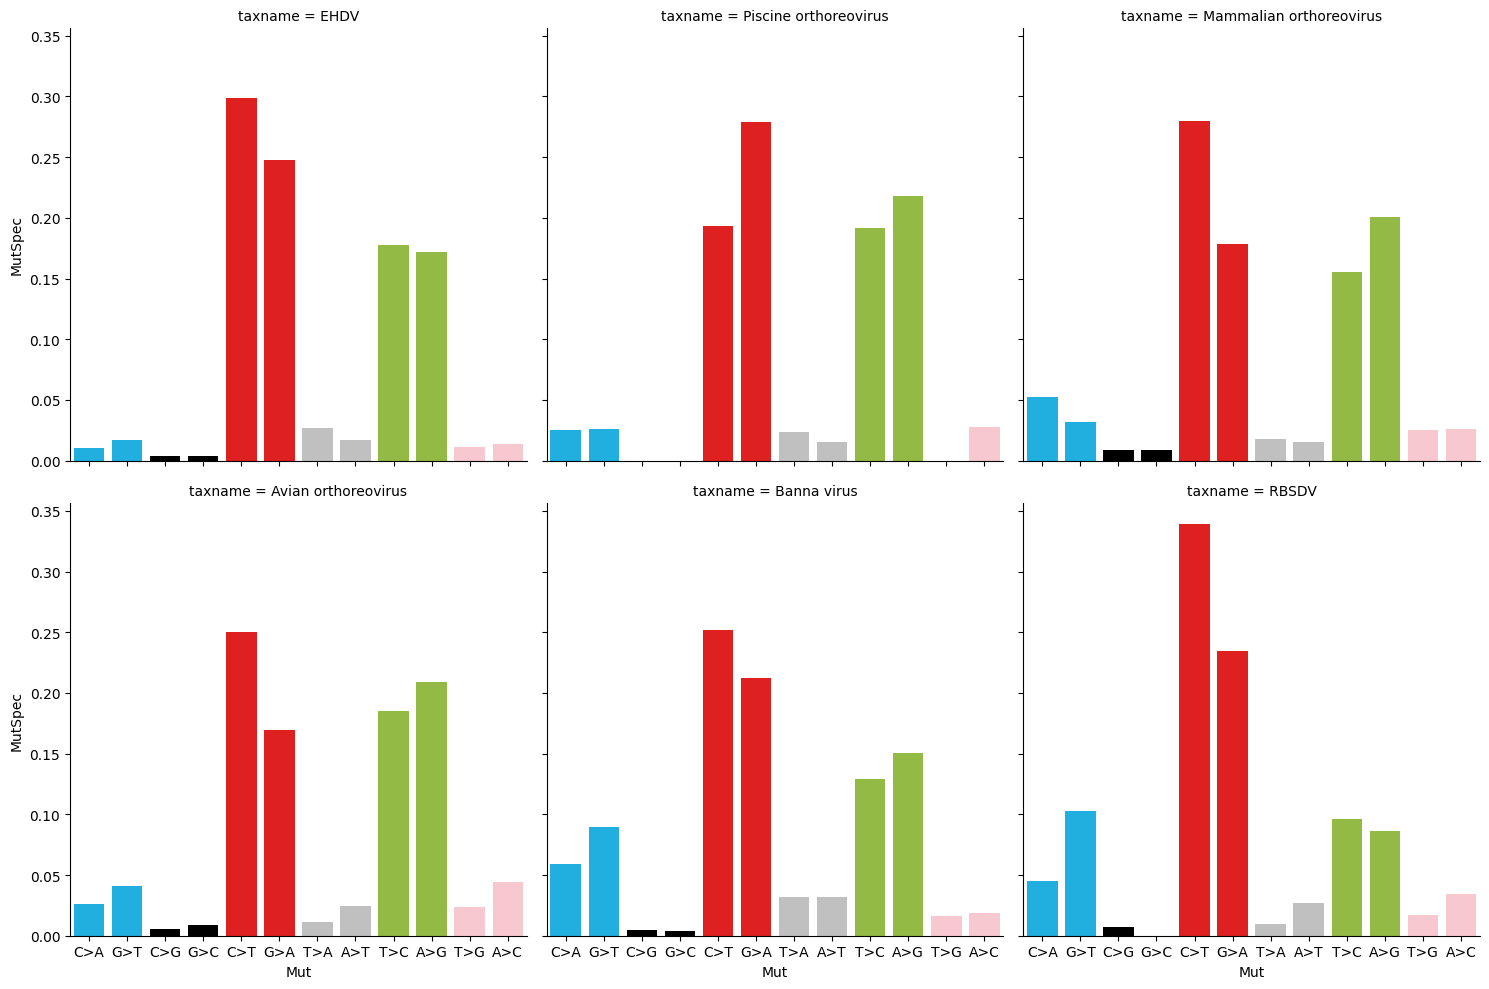

In [55]:
for tax in spectra.dropna(subset='family').family.unique():
    ms = spectra[spectra.family == tax].set_index('taxname').iloc[:, :12]
    if len(ms) > 1:
        cossim = pdist(ms, 'cosine')
        cossim_mean = cossim.mean()
        print(f"{tax}:\t{cossim_mean:.3f}\t{(1-cossim).round(2)}")
        sns.catplot(
            ms.melt(var_name='Mut', value_name='MutSpec', ignore_index=False).reset_index(), 
            x='Mut', y='MutSpec', col='taxname', 
            col_wrap=3, palette=color_mapping12, kind='bar', 
            order=color_mapping12.keys(), sharey=True)


In [5]:
from utils import prepare_exp_aa_subst, plot_exp_heatmap, plot_aa_eq_freqs

In [6]:
spectra = pd.read_csv('./data/viral_spectra_dataset.csv')

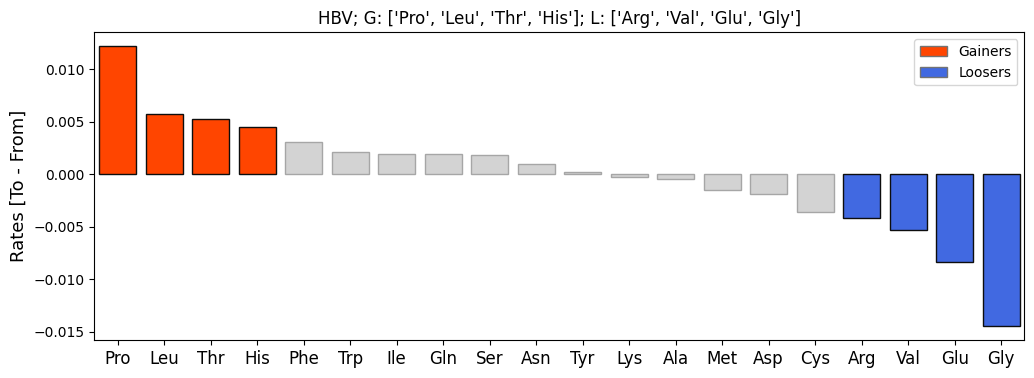

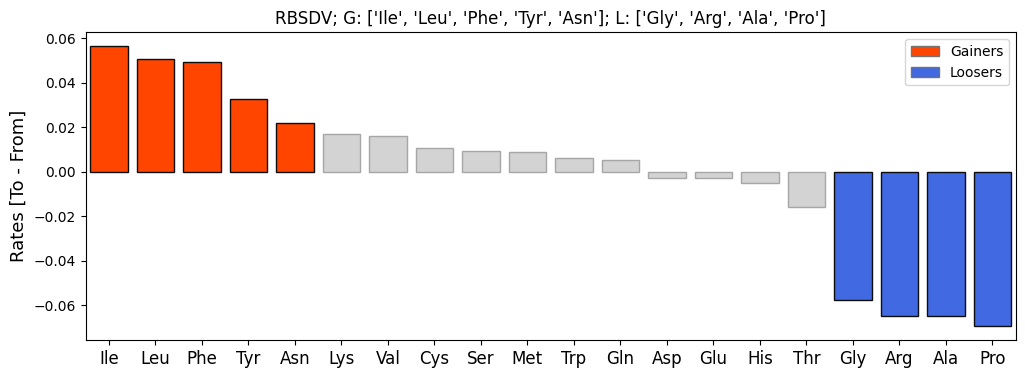

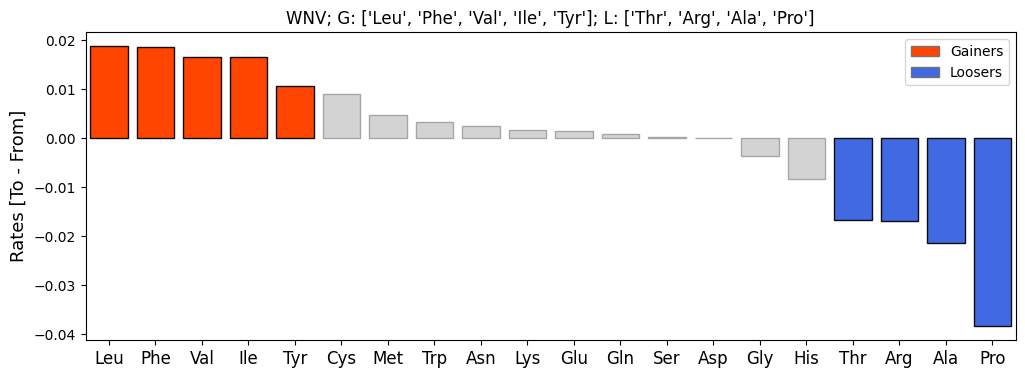

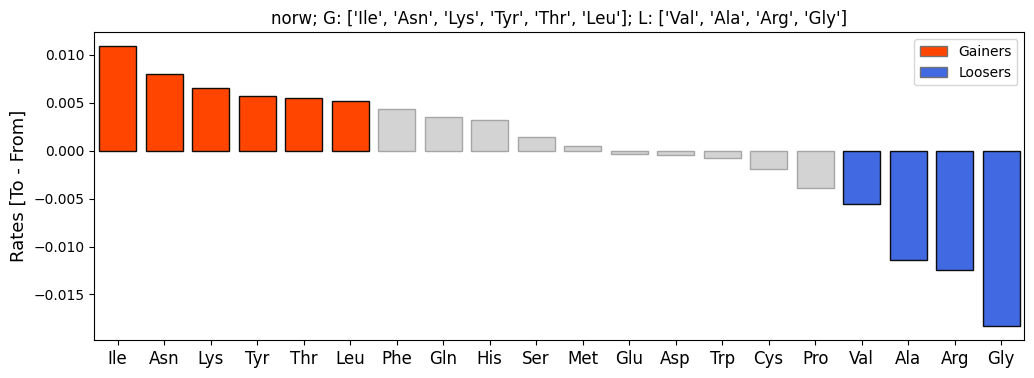

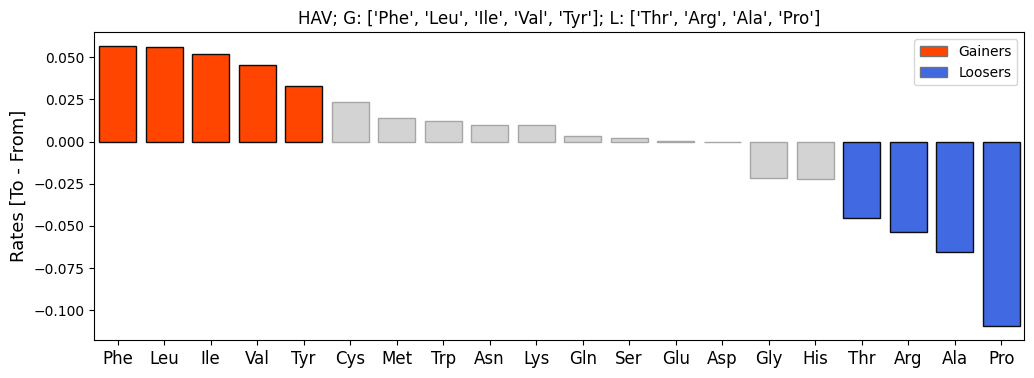

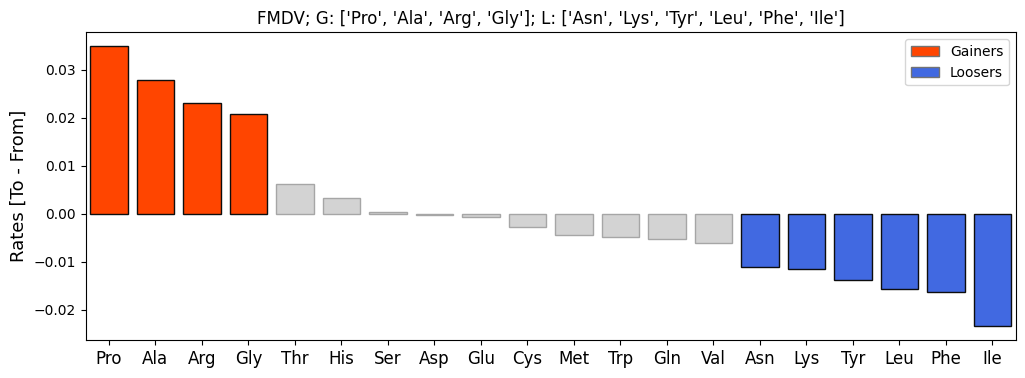

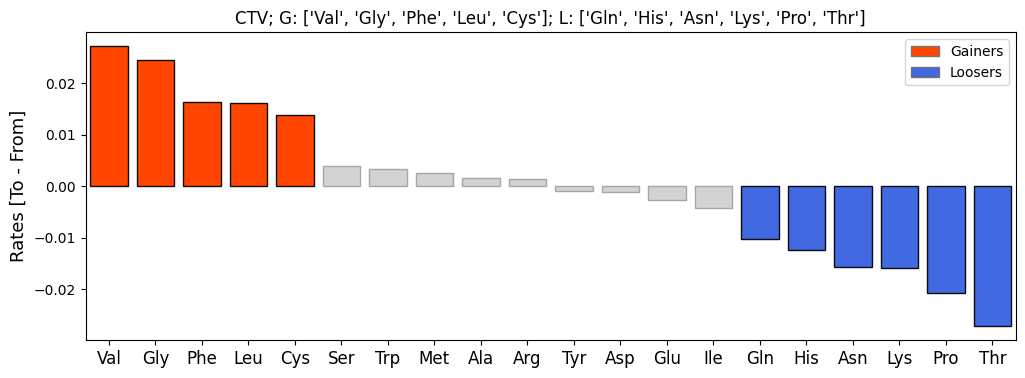

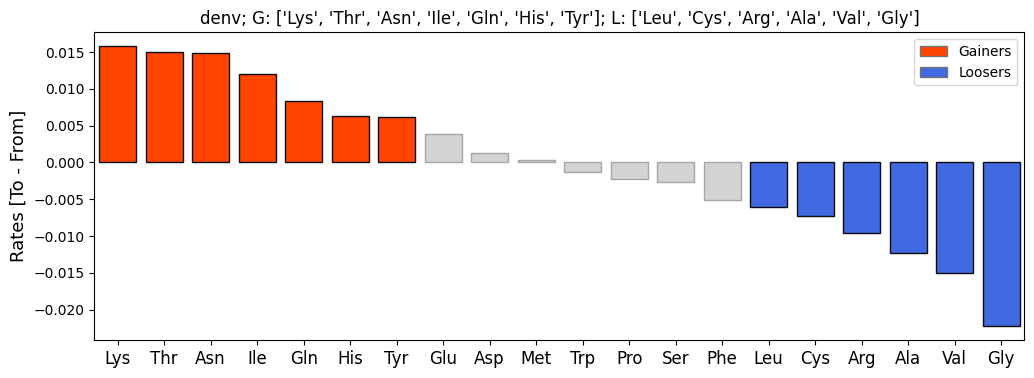

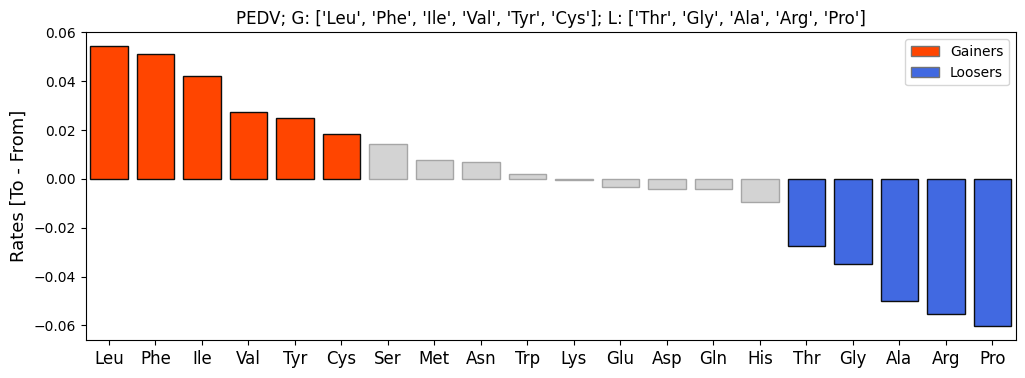

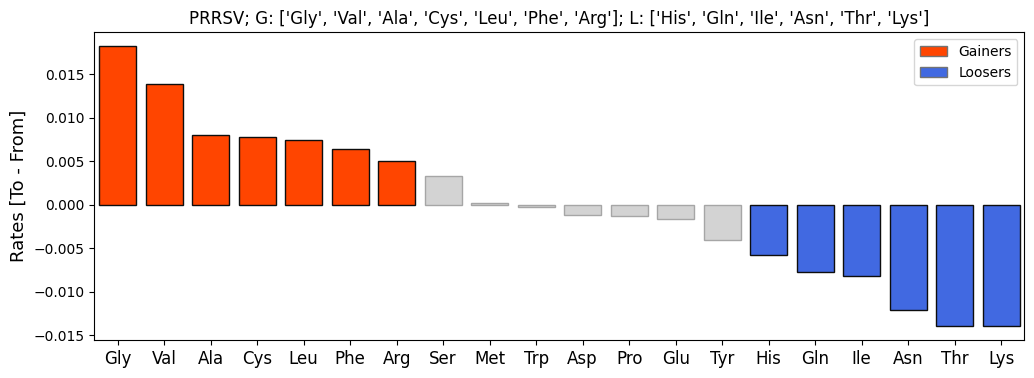

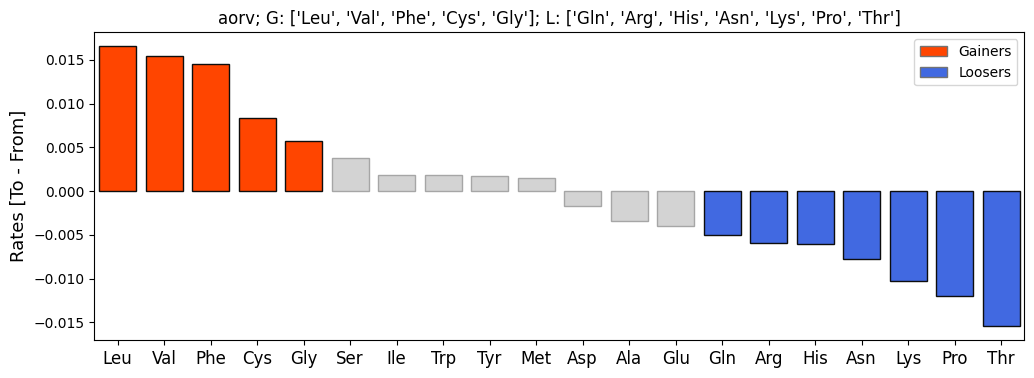

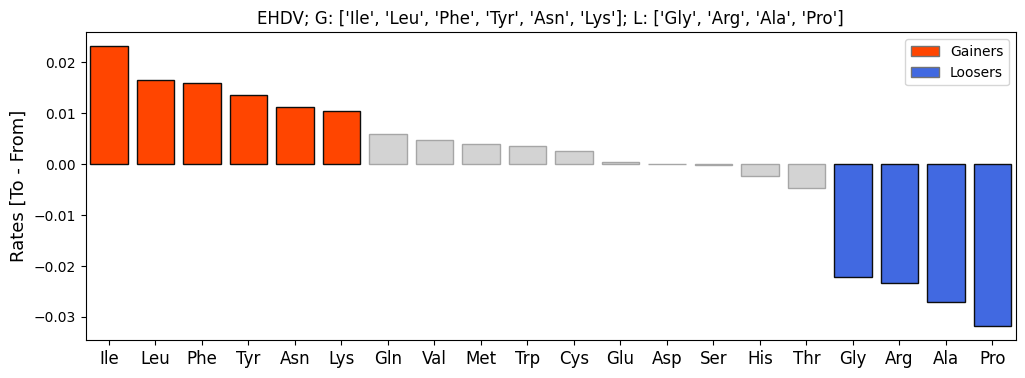

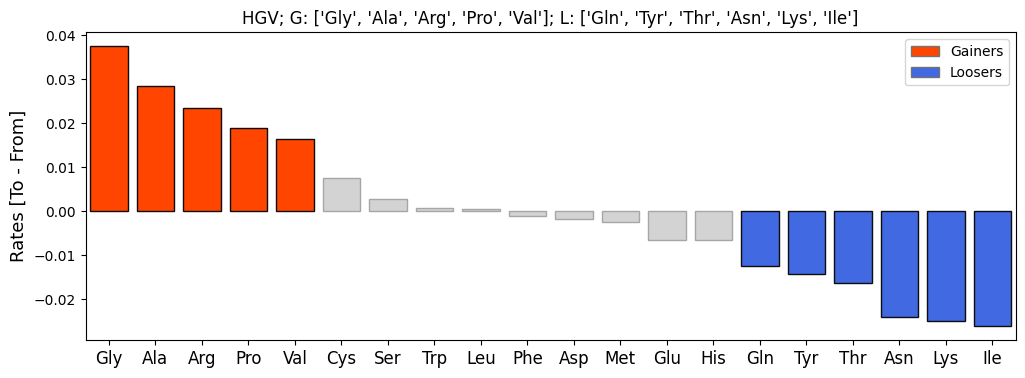

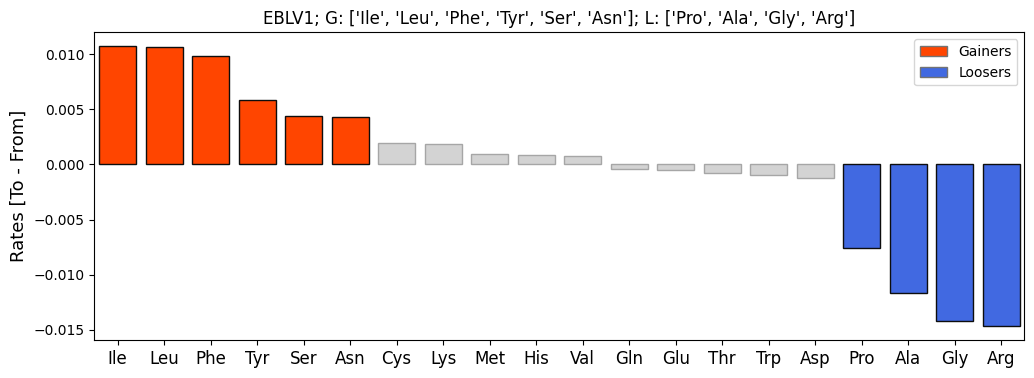

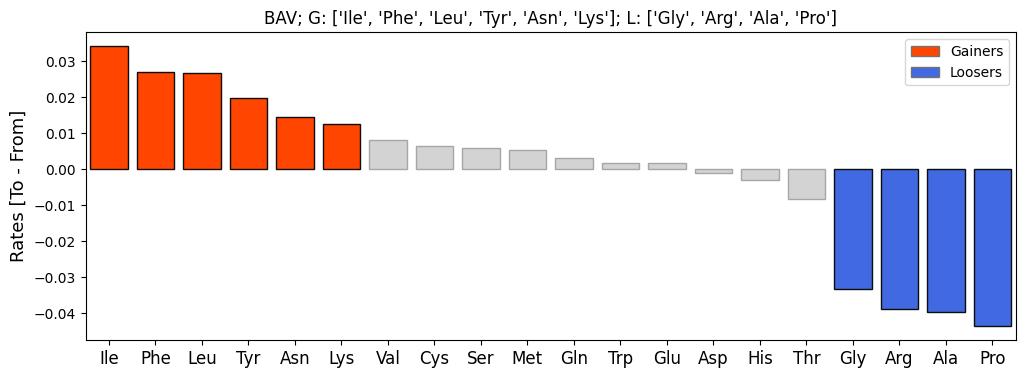

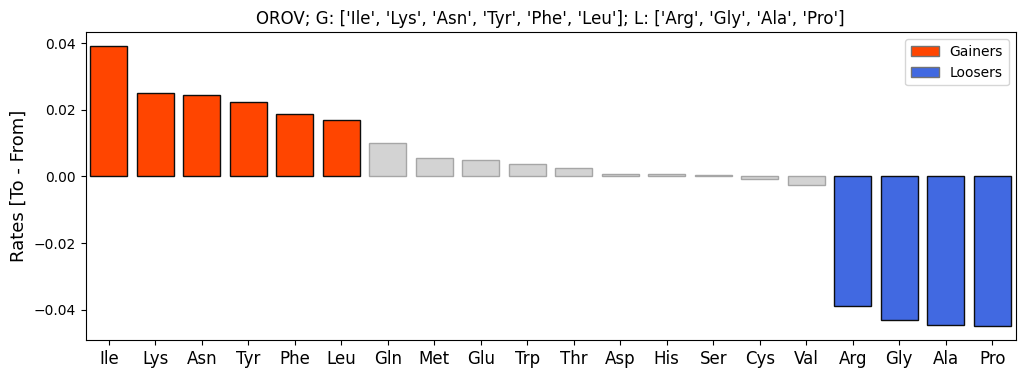

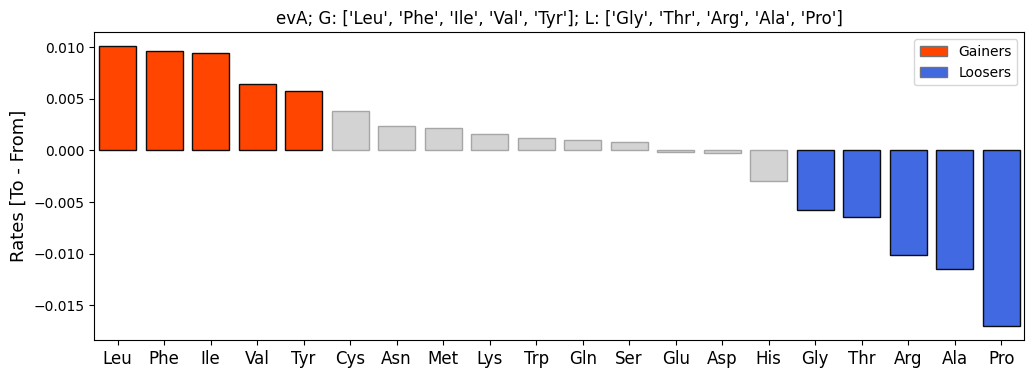

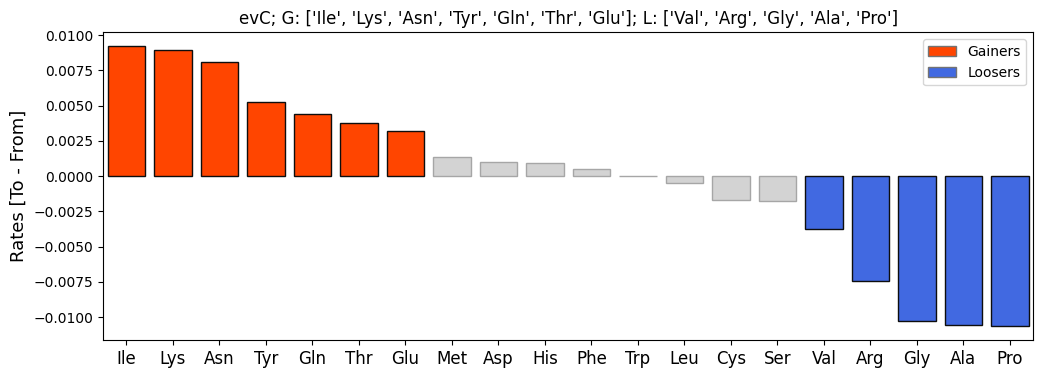

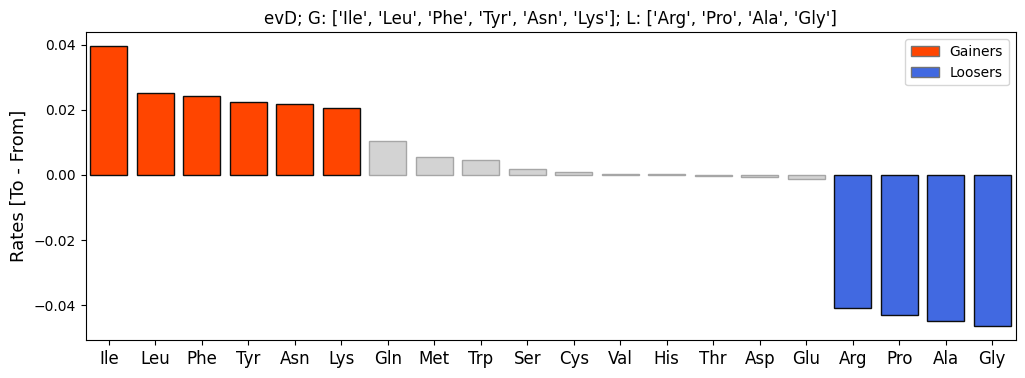

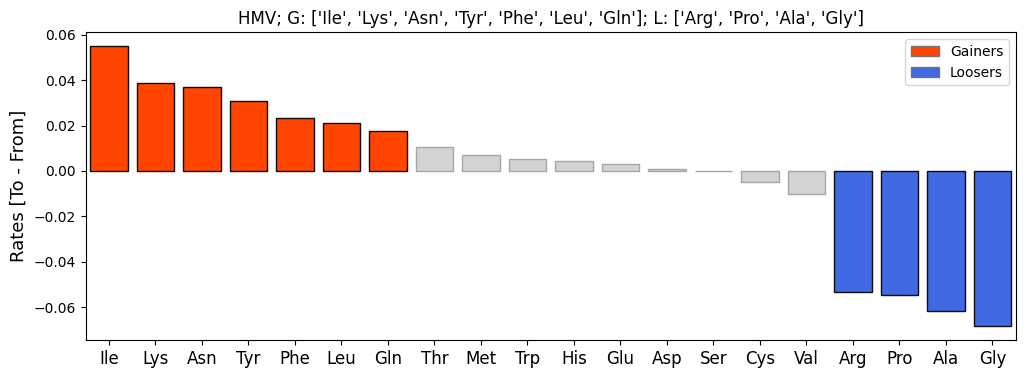

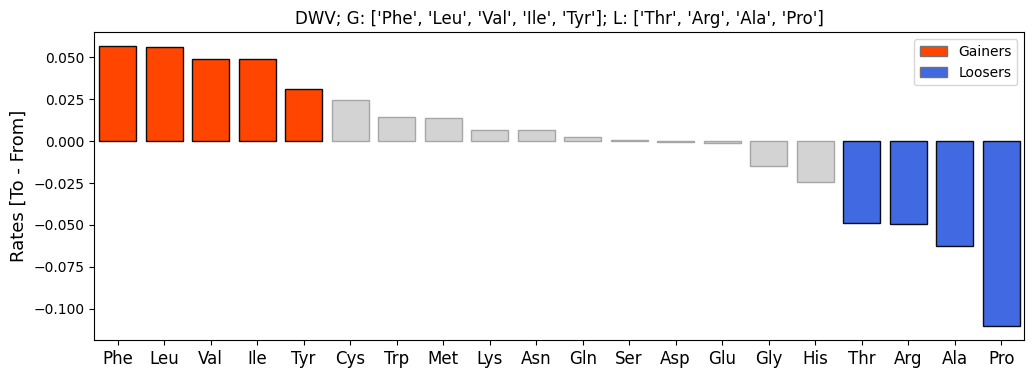

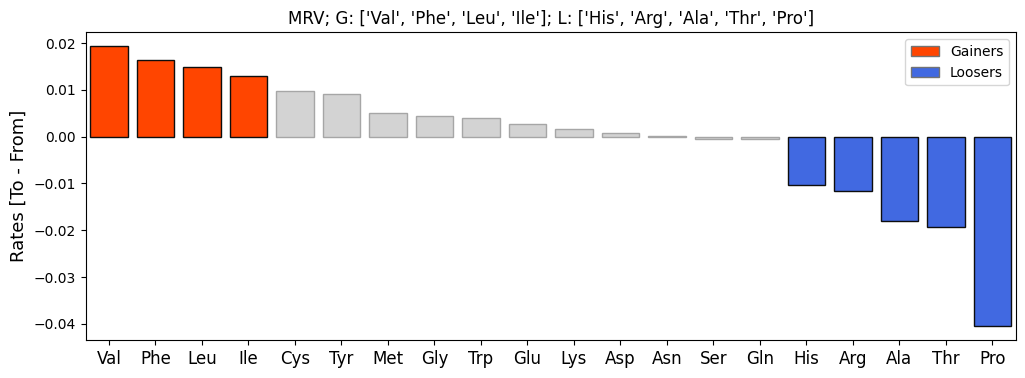

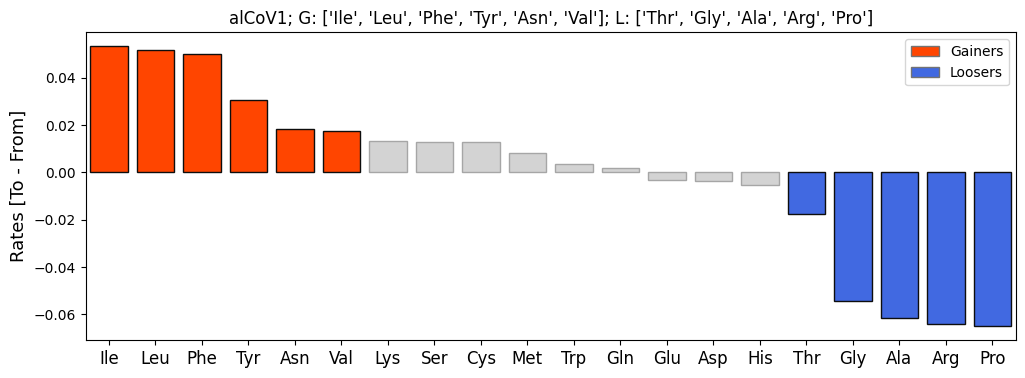

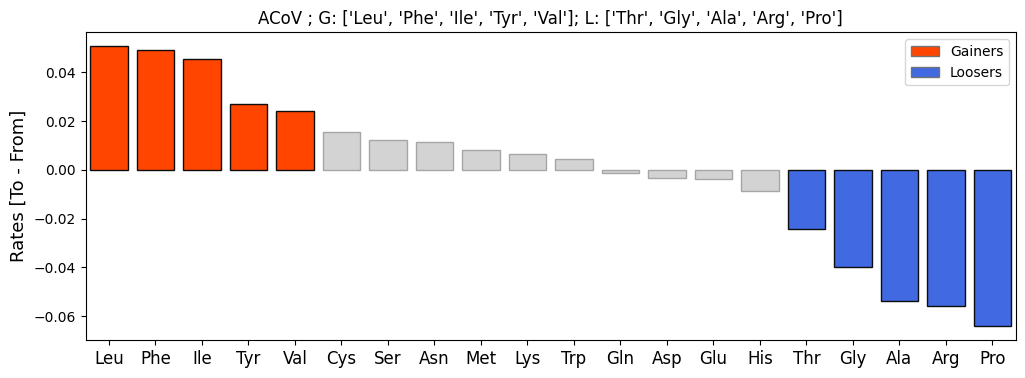

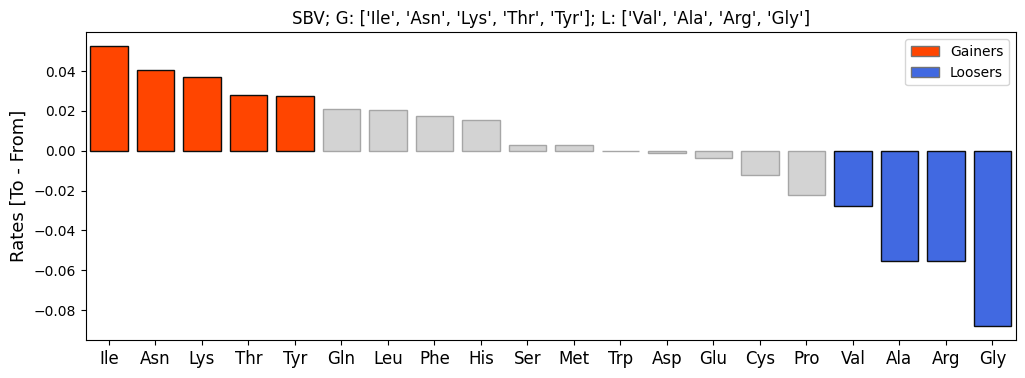

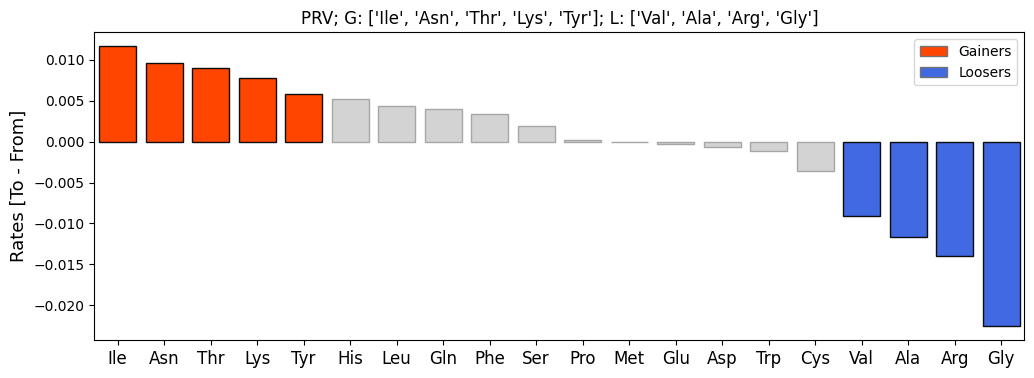

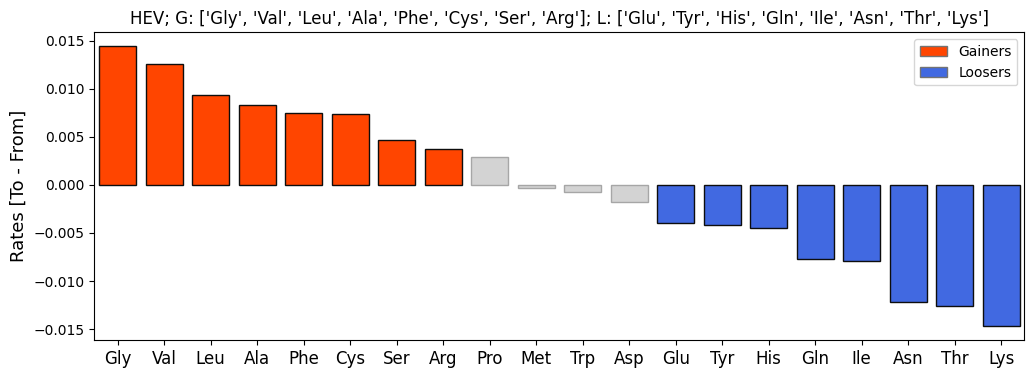

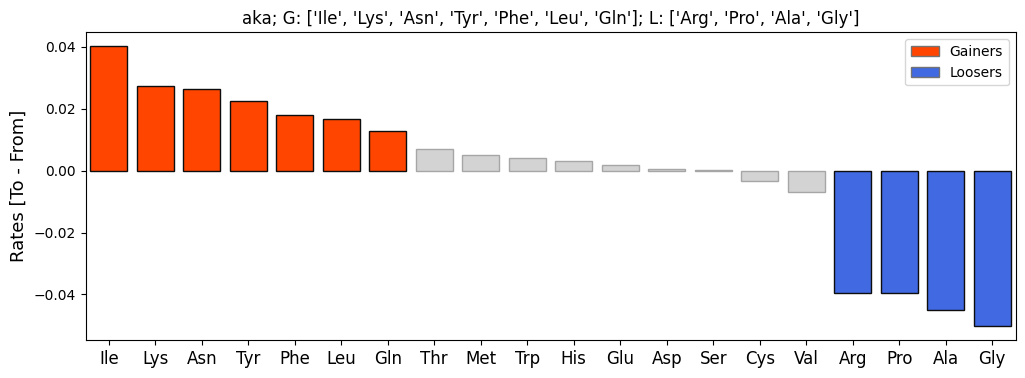

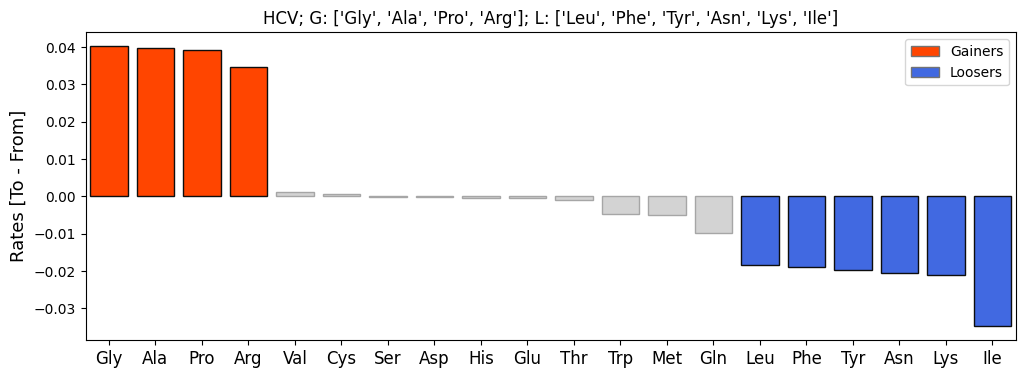

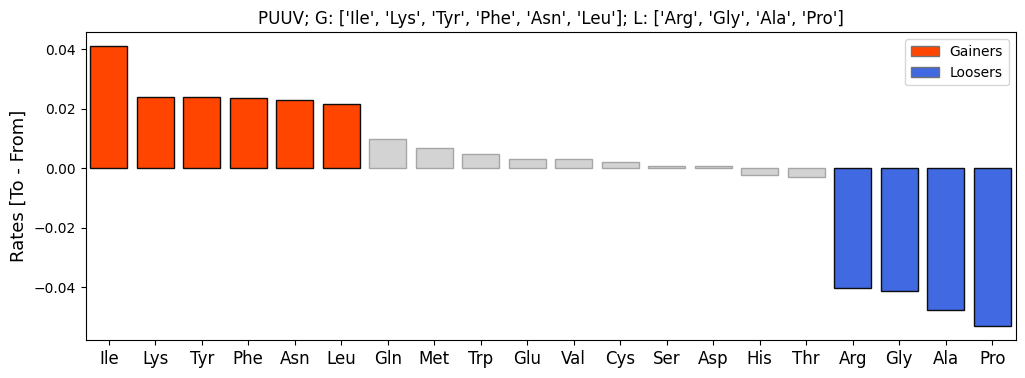

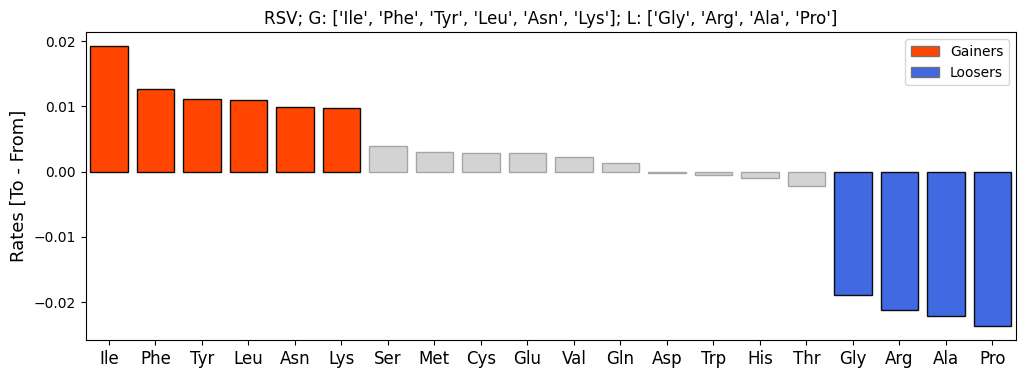

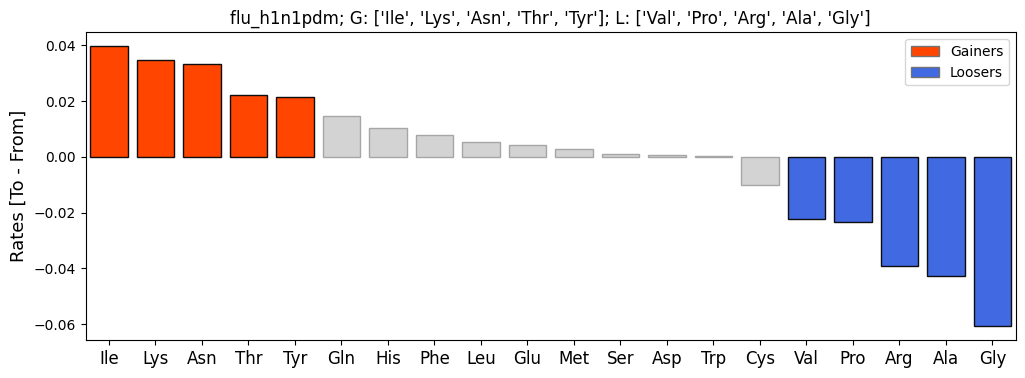

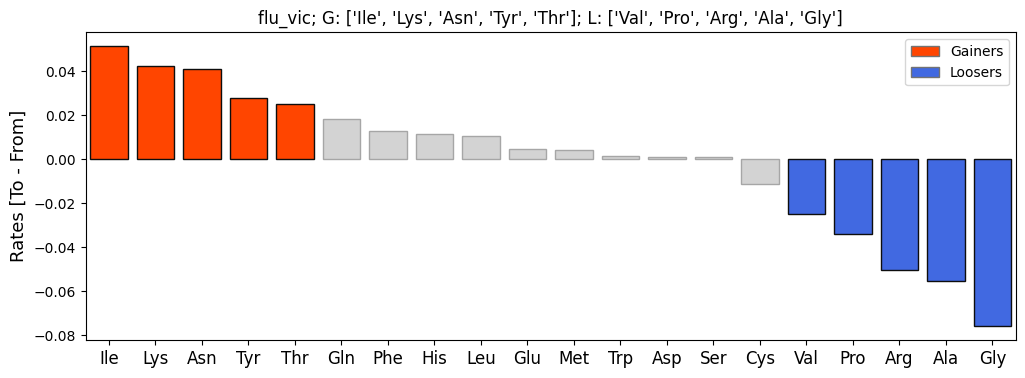

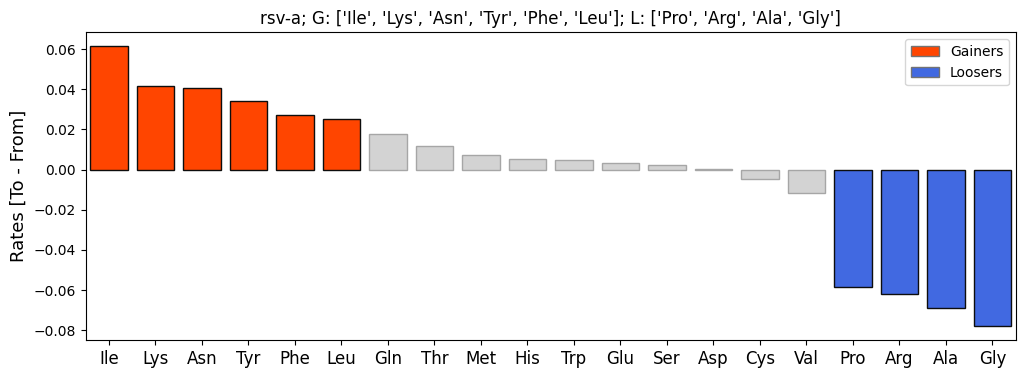

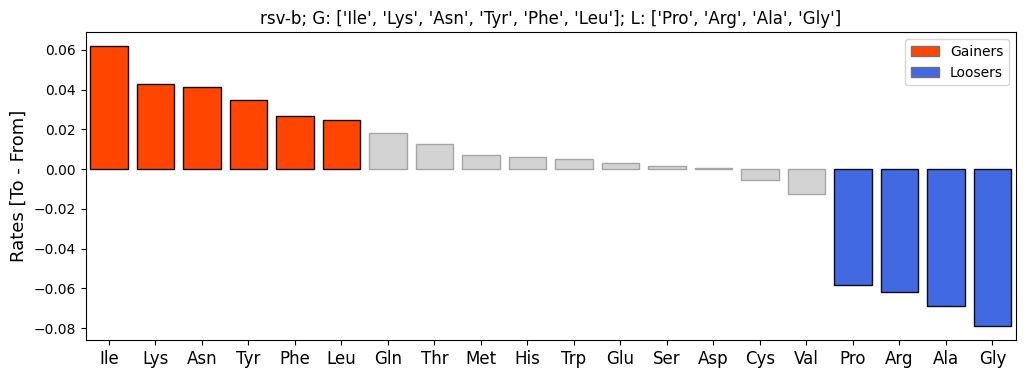

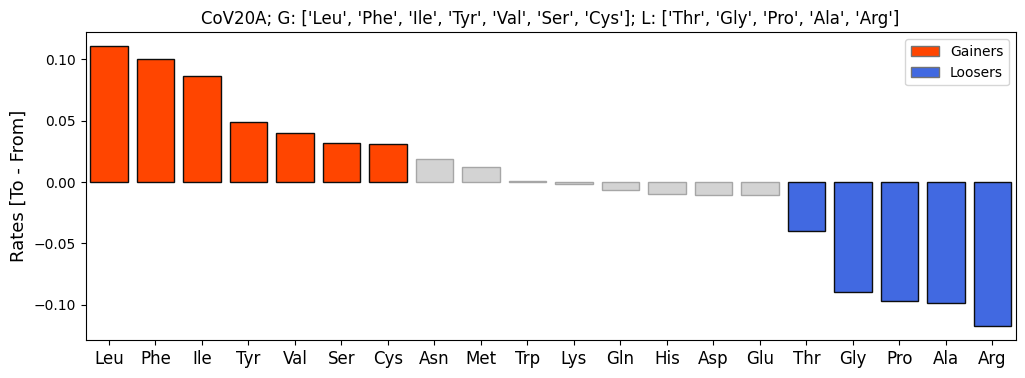

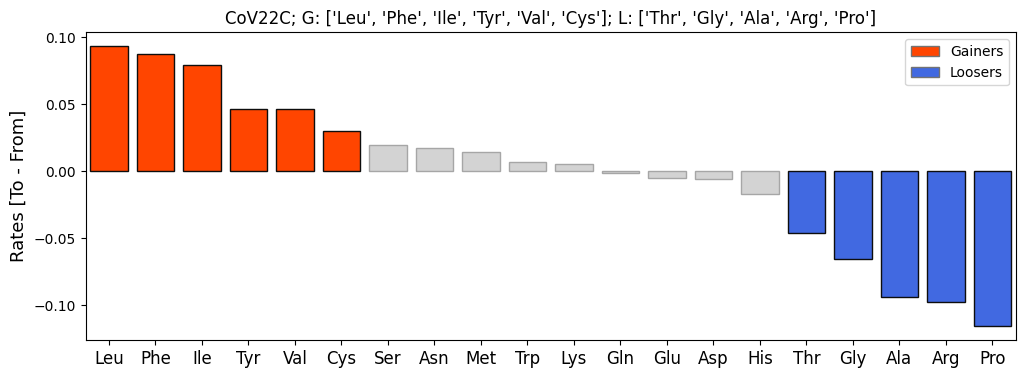

In [7]:
losers_gainers = []

for i in range(len(spectra)):
    ms12 = spectra.iloc[i, :12].reset_index()
    ms12.columns = ['Mut', 'rate']

    virusname = spectra.iloc[i]['virusname']
    taxname = spectra.iloc[i]['taxname']
    sense = spectra.iloc[i]['Type']

    exp_aa_subst, exp_aa_subst_matrix = prepare_exp_aa_subst(ms12, gc=1)

    freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
    freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

    _freqs_to = (freqs_to / freqs_to.sum()).copy()
    _freqs_from = (freqs_from / freqs_from.sum()).copy()
    _freqs_to.index.name = 'aa'
    _freqs_from.index.name = 'aa'

    flow = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

    plt.figure(figsize=(12, 4))
    ax = sns.barplot(flow, x='aa', y='Flow', color='lightgray', edgecolor=".65")

    cutoff = flow.Flow.abs().max() * 0.25

    losers_gainers.append({
        'virusname': virusname,
        'taxname': taxname,
        'sense': sense,
        'gainers': flow[flow.Flow > cutoff].aa.to_list(),
        'losers': flow[flow.Flow < -cutoff].aa.to_list(),
    })

    for bar in ax.patches:
        if bar.get_height() > cutoff:
            bar.set_color('orangered')
            bar.set_edgecolor('0.05')
        elif bar.get_height() < -cutoff:
            bar.set_color('royalblue')
            bar.set_edgecolor('0.05')


    plt.legend([
        plt.Rectangle((0,0),1,1,fc="orangered", edgecolor = '0.45'), 
        plt.Rectangle((0,0),1,1,fc='royalblue', edgecolor = '0.45'),
        ],['Gainers', 'Loosers',], loc='upper right')

    plt.title(f"{virusname}; G: {losers_gainers[i]['gainers']}; L: {losers_gainers[i]['losers']}")
    plt.ylabel('Rates [To - From]', fontsize=13)
    plt.xlabel('')
    plt.xticks(fontsize=12)
    plt.show()

In [8]:
losers_gainers_df = pd.DataFrame(losers_gainers)
losers_gainers_df['gainers'] = losers_gainers_df['gainers'].apply(lambda x: '.'.join(x))
losers_gainers_df['losers'] = losers_gainers_df['losers'].apply(lambda x: '.'.join(x))
losers_gainers_df.to_csv('./data/losers_gainers.csv', index=False)
losers_gainers_df

,virusname,taxname,sense,gainers,losers
0,HBV,Hepatitis B virus,ds,Pro.Leu.Thr.His,Arg.Val.Glu.Gly
1,RBSDV,Rice black streaked dwarf virus,ds,Ile.Leu.Phe.Tyr.Asn,Gly.Arg.Ala.Pro
2,WNV,West Nile virus,+,Leu.Phe.Val.Ile.Tyr,Thr.Arg.Ala.Pro
3,norw,Norwalk virus,+,Ile.Asn.Lys.Tyr.Thr.Leu,Val.Ala.Arg.Gly
4,HAV,Hepatovirus A,+,Phe.Leu.Ile.Val.Tyr,Thr.Arg.Ala.Pro
5,FMDV,Foot-and-mouth disease virus,+,Pro.Ala.Arg.Gly,Asn.Lys.Tyr.Leu.Phe.Ile
6,CTV,Citrus tristeza virus,+,Val.Gly.Phe.Leu.Cys,Gln.His.Asn.Lys.Pro.Thr
7,denv,Dengue virus,+,Lys.Thr.Asn.Ile.Gln.His.Tyr,Leu.Cys.Arg.Ala.Val.Gly
8,PEDV,Porcine epidemic diarrhea virus,+,Leu.Phe.Ile.Val.Tyr.Cys,Thr.Gly.Ala.Arg.Pro
9,PRRSV,Porcine reproductive and respiratory syndrome ...,+,Gly.Val.Ala.Cys.Leu.Phe.Arg,His.Gln.Ile.Asn.Thr.Lys


In [9]:
losers_gainers_df.loc[losers_gainers_df['virusname'].isin(
    ['CoV20A', 'CoV22C', 'HAV', 'DWV', 'PEDV', 'alCoV1', 'ACoV ']), 'sense']

4     +
8     +
20    +
22    +
23    +
35    +
36    +
Name: sense, dtype: object

In [10]:
losers_gainers_df = pd.DataFrame(losers_gainers)
# losers_gainers_df.loc[losers_gainers_df['virusname'].isin(
#     ['CoV20A', 'CoV22C', 'HAV', 'DWV', 'PEDV', 'alCoV1', 'ACoV ']), 'sense'] = \
#     ['+(Cov-like)']*7
losers_gainers_df

,virusname,taxname,sense,gainers,losers
0,HBV,Hepatitis B virus,ds,"[Pro, Leu, Thr, His]","[Arg, Val, Glu, Gly]"
1,RBSDV,Rice black streaked dwarf virus,ds,"[Ile, Leu, Phe, Tyr, Asn]","[Gly, Arg, Ala, Pro]"
2,WNV,West Nile virus,+,"[Leu, Phe, Val, Ile, Tyr]","[Thr, Arg, Ala, Pro]"
3,norw,Norwalk virus,+,"[Ile, Asn, Lys, Tyr, Thr, Leu]","[Val, Ala, Arg, Gly]"
4,HAV,Hepatovirus A,+,"[Phe, Leu, Ile, Val, Tyr]","[Thr, Arg, Ala, Pro]"
5,FMDV,Foot-and-mouth disease virus,+,"[Pro, Ala, Arg, Gly]","[Asn, Lys, Tyr, Leu, Phe, Ile]"
6,CTV,Citrus tristeza virus,+,"[Val, Gly, Phe, Leu, Cys]","[Gln, His, Asn, Lys, Pro, Thr]"
7,denv,Dengue virus,+,"[Lys, Thr, Asn, Ile, Gln, His, Tyr]","[Leu, Cys, Arg, Ala, Val, Gly]"
8,PEDV,Porcine epidemic diarrhea virus,+,"[Leu, Phe, Ile, Val, Tyr, Cys]","[Thr, Gly, Ala, Arg, Pro]"
9,PRRSV,Porcine reproductive and respiratory syndrome ...,+,"[Gly, Val, Ala, Cys, Leu, Phe, Arg]","[His, Gln, Ile, Asn, Thr, Lys]"


In [22]:
losers_gainers_df.set_index('sense')['gainers'].index.value_counts().to_dict()

{'+': 19, '-': 11, 'ds': 7}

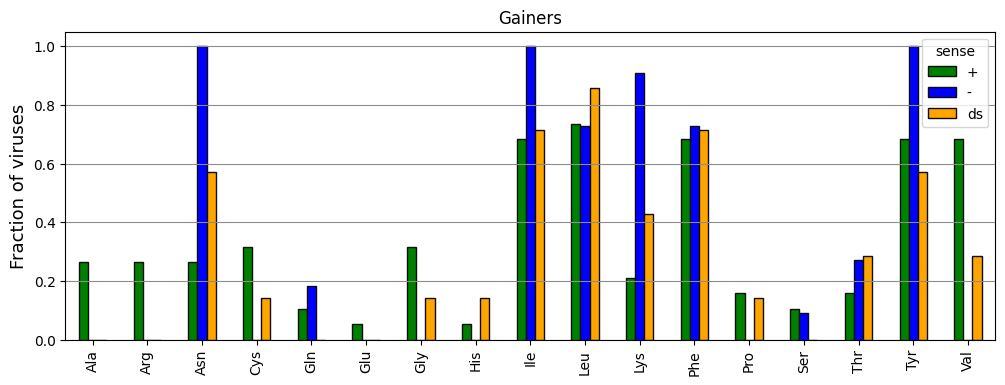

In [ ]:
(losers_gainers_df.set_index('sense')['gainers'].explode().reset_index()\
    .groupby('sense').value_counts().unstack().fillna(0).astype(int).T / \
        losers_gainers_df.set_index('sense')['gainers'].index.value_counts().to_dict())\
        .plot.bar(stacked=False, figsize=(12, 4), 
                  color=['green', 'blue', 'orange'], edgecolor='0.05')
plt.ylabel('Fraction of viruses', fontsize=13)
plt.title('Gainers')
plt.xlabel('')
plt.grid(axis='y', color='0.55')
plt.show()

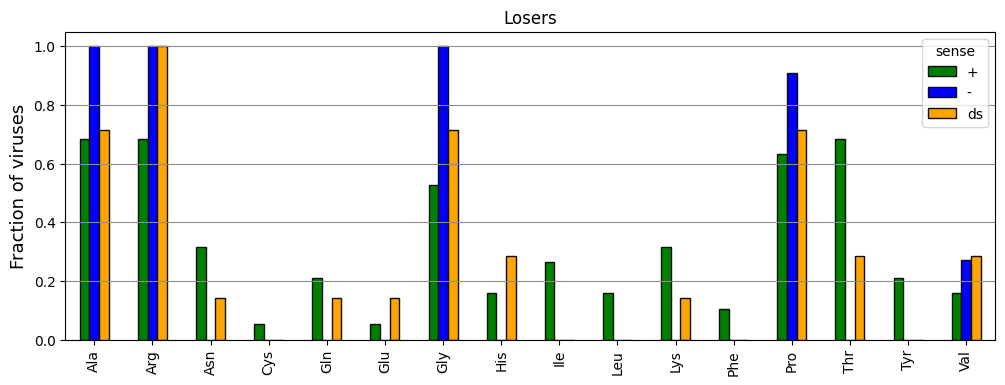

In [38]:
(losers_gainers_df.set_index('sense')['losers'].explode().reset_index()\
    .groupby('sense').value_counts().unstack().fillna(0).astype(int).T / \
        losers_gainers_df.set_index('sense')['gainers'].index.value_counts().to_dict())\
        .plot.bar(stacked=False, figsize=(12, 4), 
                  color=['green', 'blue', 'orange'], edgecolor='0.05')
plt.ylabel('Fraction of viruses', fontsize=13)
plt.title('Losers')
plt.xlabel('')
plt.grid(axis='y', color='0.55')
plt.show()

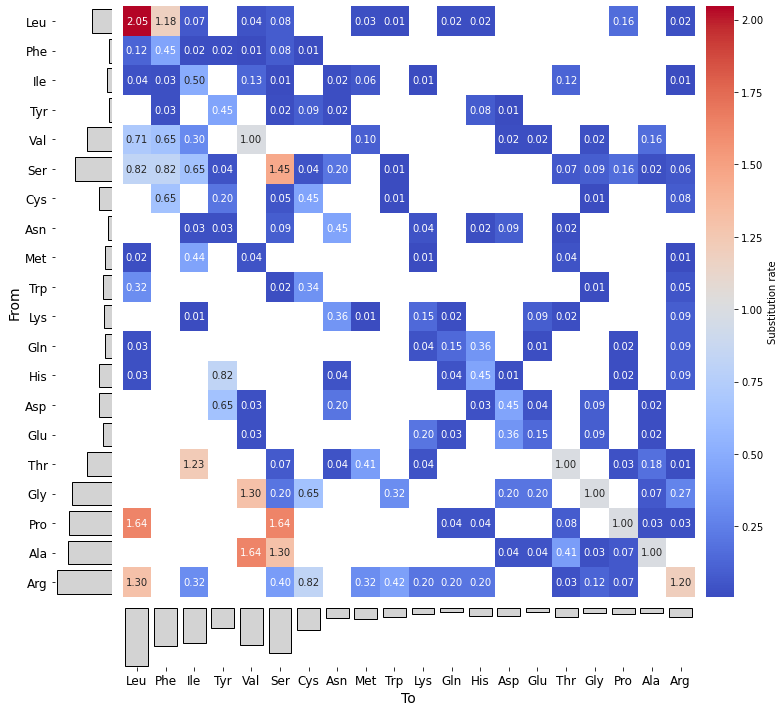

In [60]:
ms12 = spectra.iloc[-2, :12].reset_index()
ms12.columns = ['Mut', 'rate']

virusname = spectra.iloc[i]['virusname']
taxname = spectra.iloc[i]['taxname']

_, exp_aa_subst_matrix = prepare_exp_aa_subst(ms12, gc=1)

freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

flow = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

plot_exp_heatmap(exp_aa_subst_matrix.loc[flow.aa, flow.aa], '/tmp/bn.pdf', show=True, annot=True)